## Module 2: Explaining Models (ALE, MDI+)

In this note will revisit the income prediction problem to form global, rather
than local, explanations. We will use the `alibi` and `imodels` packages to
create ALE and MDI+ summaries, respectively. The ALE plots will apply to the
same gradient boosting model from our previous example, while MDI+ will be
tailored for a new random forest model. If you setup the conda environment from
the previous module, you can continue to use it (environment `iisa310`).

In [1]:
from alibi.explainers import ALE, plot_ale
import lightgbm as lgb
import shap

Before we generate the ALE summary, let's refit the same gradient boosting model from before.

In [2]:
X, y = shap.datasets.adult()
data = lgb.Dataset(X, y)
model = lgb.train({"learning_rate": 0.05}, data, 1000)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 431
[LightGBM] [Info] Number of data points in the train set: 32561, number of used features: 12
[LightGBM] [Info] Start training from score 0.240810


ALE takes the model's prediction function and the list of potential features as
input. Given the ALE object, we can form the ALE plot for any individual feature
its associated `.explain` method, and we can use the package's built in function
to plot the result.

array([[<Axes: xlabel='Age', ylabel='ALE'>,
        <Axes: xlabel='Capital Gain', ylabel='ALE'>]], dtype=object)

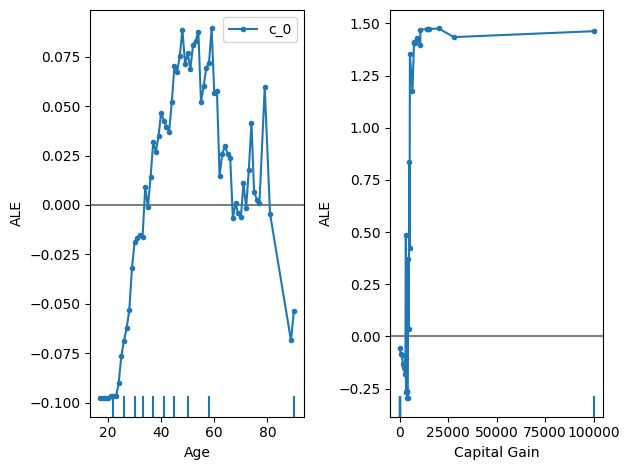

In [3]:
ale = ALE(model.predict, feature_names=X.columns.tolist())
explanation = ale.explain(X.values, features=[0, 8])
plot_ale(explanation, sharey="None")

ALE applies to any model. In contrast, MDI+ can only apply to tree-based models.
The code below fits a new random forest+ model to the same income prediction
problem. The random forest+ model fits a linear model using features derived
from the original random forest model. Since the problem is classification, this
is just a logistic regression model applied to tree features. We're fitting a
quite small model to just a subset of the data, because we want this code to run
relatively quickly. Of course, using all samples would lead to more precise MDI+
scores.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from imodels.importance import RandomForestPlusClassifier
import numpy as np

classifier = RandomForestClassifier(n_estimators=50)
model = RandomForestPlusClassifier(rf_model=classifier)
ix = np.random.choice(X.index, size=1000)
model.fit(X.loc[ix, :], y[ix])

The block above fit the original model, adn we can use the `get_mdi_plus_scores`
wrapper method to get scores for each feature. Note that, in our original
discussion, these are just $R^{2}$ values between the full and
$k^{\text{th}}$-submodel predictions, because there we had been focused on
regression problesm. Here, though, we are using classification. In this case,
the package uses the negative binary cross entropy between the full and
$k^{\text{th}}$ submodel predictions. A cross entropy value closer to 0 means
that using that subset alone can nearly recover the original, full model
probabilities.

In [5]:
mdi_plus_scores = model.get_mdi_plus_scores(X.iloc[ix, :], y[ix])
mdi_plus_scores.sort_values(by='importance', ascending=False)

,var,importance
5,Relationship,-0.504932
2,Education-Num,-0.525052
8,Capital Gain,-0.569150
3,Marital Status,-0.579427
0,Age,-0.583054
10,Hours per week,-0.588159
4,Occupation,-0.614793
9,Capital Loss,-0.615444
6,Race,-0.617515
11,Country,-0.619030
